In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import io
import datetime
import matplotlib.lines as mlines
from fredapi import Fred
import statsmodels.formula.api as smf
import datetime

In [185]:
interest = pd.read_csv('final.csv', index_col = 0, parse_dates = True)
interest.columns = ["I_US", "I_AU", "AUD"]
interest

,I_US,I_AU,AUD
Date,,,
1980-01-01,13.39,10.03,1.1067
1980-02-01,14.30,10.06,1.0970
1980-03-01,17.57,11.47,1.0818
1980-04-01,16.14,13.28,1.1150
1980-05-01,9.79,13.83,1.1428
...,...,...,...
2022-08-01,2.76,2.31,0.6866
2022-09-01,3.21,2.76,0.6437
2022-10-01,3.85,2.95,0.6394


Text(0.5, 1.0, 'AU Interbank Rate')

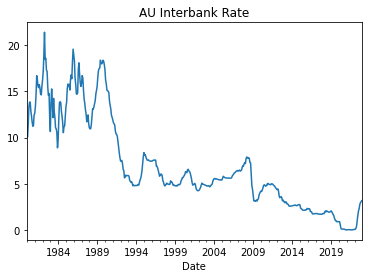

In [3]:
interest["I_AU"].dropna().plot()
plt.title("AU Interbank Rate")

<AxesSubplot:title={'center':'Interest Rate Differential With Scaling'}, xlabel='Date'>

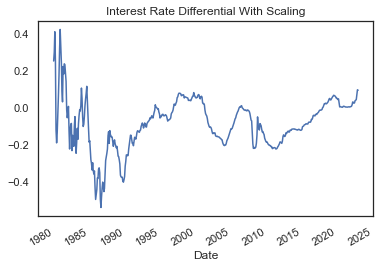

In [186]:
# Implement min max scaling in a function
def scale(x):
    return (x-x.min())/(x.max()-x.min())

# Apply Scaling
interest["ir_diff"] = scale(interest["I_US"]) - scale(interest["I_AU"])
interest.dropna(inplace= True)

plt.title("Interest Rate Differential With Scaling")
interest["ir_diff"].plot()

In [5]:
# specify candidate values for hyperparameters
ks = np.linspace(.01, .99, 10)
zs = np.linspace(.01, 3, 10)
ws = np.arange(5, 30, 5)
# hs =  np.arange(1,120, 32)
# hs = np.array([1, 3, 6, 12, 24])
hs = 6

import itertools as it
# build a grid with all possible hyperparameters
grid = np.array(np.meshgrid(ks,zs, ws, hs)).T.reshape(-1,4)


In [187]:
interest["Returns"] = np.log(interest["AUD"]).diff()

In [7]:
storage = pd.DataFrame(columns = ["k", "z", "w", "h", "profits"])
df_copy = interest.copy()

for n in range(len(grid)):
    # Each loop we pull out the values for a new set of hyperparamters from the grid
    k,z,w,h= grid[n]
    
    # We fit a filter and CI using the next set of parameters
    df_copy["Filter"] = df_copy["ir_diff"].ewm(alpha = k, adjust = False).mean()
    df_copy["Filter Error"] = df_copy["ir_diff"] -df_copy["Filter"]
    df_copy["std"] = df_copy["Filter Error"].rolling(int(w)).std()
    df_copy["Upper"] = df_copy["Filter"] + z*df_copy["std"]
    df_copy["Lower"] = df_copy["Filter"] - z*df_copy["std"]
    df_copy["test"] = np.where(df_copy["Filter Error"].abs()>z*df_copy["std"], 1, 0)*np.sign(df_copy["Filter Error"])
    
    # create vectors where we can store information on signals and when the change is first signalled
    df_copy["test2"] = 0
    df_copy["signal"] = 0
    
    for j in df_copy.index:
        # if there is a change in the signal, we want to take a position for teh next h periods
        if (df_copy.loc[j, "test"] == 1) &  (df_copy.shift().loc[j, "test"] != 1):
            df_copy.loc[j:j+datetime.timedelta(h), "signal"] = 1
            df_copy.loc[j, "test2"] = 1
        elif (df_copy.loc[j, "test"] == -1) &  (df_copy.shift().loc[j, "test"] != -1):
            df_copy.loc[j:j+datetime.timedelta(h), "signal"] =  -1
            df_copy.loc[j, "test2"] = -1
    
    # calculate metric
    df_copy["cumulative_returns"] = np.exp((df_copy["signal"].shift()*df_copy.Returns).cumsum())-1
    
    # store the results
    storage = storage.append({"k":k, "z":z, "w":w, "h":h,
                "profits":df_copy["cumulative_returns"][-1]}, ignore_index = True)
    # print so I can track progress of loop (can take a few minutes)
    print(n)

/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


0


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


3


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


4


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


5


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


6


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


7


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


8


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


9


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


10


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


11


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


12


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


13


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


14


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


15


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


16


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


17


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


18


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


19


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


20


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


21


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


22


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


23


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


24


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


25


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


26


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


27


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


28


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


29


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


30


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


31


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


32


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


33


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


34


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


35


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


36


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


37


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


38


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


39


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


40


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


41


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


42


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


43


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


44


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


45


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


46


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


47


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


48


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


49


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


50


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


51


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


52


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


53


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


54


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


55


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


56


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


57


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


58


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


59


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


60


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


61


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


62


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


63


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


64


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


65


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


66


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


67


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


68


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


69


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


70


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


71


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


72


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


73


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


74


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


75


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


76


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


77


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


78


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


79


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


80


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


81


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


82


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


83


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


84


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


85


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


86


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


87


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


88


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


89


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


90


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


91


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


92


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


93


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


94


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


95


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


96


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


97


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


98


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


99


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


100


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


101


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


102


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


103


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


104


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


105


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


106


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


107


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


108


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


109


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


110


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


111


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


112


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


113


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


114


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


115


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


116


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


117


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


118


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


119


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


120


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


121


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


122


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


123


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


124


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


125


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


126


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


127


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


128


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


129


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


130


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


131


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


132


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


133


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


134


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


135


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


136


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


137


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


138


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


139


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


140


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


141


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


142


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


143


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


144


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


145


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


146


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


147


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


148


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


149


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


150


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


151


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


152


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


153


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


154


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


155


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


156


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


157


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


158


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


159


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


160


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


161


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


162


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


163


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


164


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


165


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


166


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


167


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


168


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


169


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


170


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


171


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


172


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


173


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


174


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


175


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


176


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


177


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


178


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


179


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


180


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


181


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


182


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


183


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


184


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


185


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


186


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


187


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


188


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


189


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


190


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


191


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


192


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


193


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


194


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


195


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


196


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


197


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


198


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


199


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


200


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


201


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


202


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


203


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


204


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


205


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


206


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


207


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


208


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


209


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


210


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


211


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


212


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


213


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


214


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


215


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


216


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


217


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


218


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


219


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


220


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


221


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


222


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


223


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


224


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


225


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


226


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


227


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


228


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


229


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


230


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


231


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


232


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


233


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


234


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


235


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


236


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


237


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


238


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


239


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


240


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


241


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


242


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


243


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


244


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


245


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


246


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


247


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


248


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


249


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


250


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


251


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


252


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


253


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


254


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


255


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


256


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


257


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


258


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


259


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


260


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


261


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


262


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


263


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


264


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


265


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


266


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


267


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


268


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


269


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


270


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


271


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


272


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


273


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


274


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


275


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


276


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


277


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


278


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


279


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


280


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


281


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


282


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


283


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


284


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


285


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


286


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


287


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


288


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


289


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


290


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


291


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


292


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


293


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


294


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


295


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


296


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


297


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


298


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


299


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


300


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


301


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


302


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


303


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


304


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


305


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


306


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


307


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


308


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


309


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


310


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


311


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


312


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


313


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


314


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


315


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


316


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


317


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


318


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


319


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


320


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


321


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


322


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


323


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


324


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


325


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


326


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


327


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


328


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


329


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


330


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


331


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


332


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


333


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


334


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


335


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


336


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


337


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


338


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


339


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


340


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


341


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


342


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


343


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


344


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


345


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


346


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


347


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


348


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


349


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


350


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


351


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


352


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


353


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


354


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


355


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


356


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


357


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


358


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


359


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


360


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


361


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


362


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


363


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


364


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


365


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


366


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


367


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


368


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


369


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


370


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


371


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


372


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


373


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


374


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


375


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


376


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


377


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


378


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


379


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


380


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


381


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


382


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


383


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


384


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


385


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


386


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


387


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


388


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


389


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


390


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


391


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


392


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


393


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


394


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


395


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


396


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


397


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


398


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


399


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


400


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


401


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


402


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


403


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


404


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


405


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


406


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


407


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


408


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


409


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


410


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


411


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


412


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


413


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


414


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


415


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


416


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


417


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


418


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


419


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


420


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


421


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


422


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


423


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


424


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


425


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


426


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


427


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


428


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


429


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


430


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


431


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


432


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


433


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


434


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


435


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


436


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


437


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


438


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


439


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


440


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


441


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


442


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


443


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


444


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


445


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


446


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


447


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


448


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


449


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


450


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


451


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


452


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


453


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


454


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


455


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


456


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


457


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


458


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


459


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


460


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


461


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


462


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


463


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


464


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


465


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


466


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


467


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


468


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


469


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


470


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


471


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


472


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


473


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


474


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


475


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


476


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


477


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


478


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


479


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


480


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


481


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


482


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


483


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


484


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


485


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


486


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


487


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


488


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


489


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


490


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


491


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


492


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


493


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


494


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


495


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


496


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


497


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


498
499


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/1344092893.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


In [8]:
storage = storage.sort_values(by = "proMallikafits").reset_index(drop = True)
storage

,k,z,w,h,profits
0,0.99,0.342222,5.0,6.0,-0.503098
1,0.99,0.342222,20.0,6.0,-0.469625
2,0.336667,1.338889,5.0,6.0,-0.453509
3,0.663333,0.01,20.0,6.0,-0.443715
4,0.336667,1.006667,20.0,6.0,-0.434341
...,...,...,...,...,...
495,0.118889,0.342222,10.0,6.0,0.496489
496,0.336667,2.335556,5.0,6.0,0.553348
497,0.118889,1.338889,5.0,6.0,0.575329
498,0.118889,0.342222,20.0,6.0,0.601305


In [9]:
import seaborn as sns
def heatmap(x, y, metric, values):
    
    # specify the columns I will be pulling from the results
    p2p = values[[x, y, metric]]
    
    # If p > 2, we need to group 
    heat = np.round(p2p.groupby([x,y]).max(),1)
    heat = heat.unstack()[metric]

    # round labels
    heat.index = np.round(heat.index,2)
    heat.columns = np.round(heat.columns,2)

    # make plot
    f, ax = plt.subplots(figsize=(25, 12))
    ax = sns.heatmap(heat, fmt='.1g')
    ax.set_title("Heat map of "+ metric,size = 18)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.set_xlabel(y, size = 18)
    ax.set_ylabel(x, size = 18)
    ax.collections[0].colorbar.set_label(metric, size = 18)
    sns.set(font_scale=1)
    plt.show()

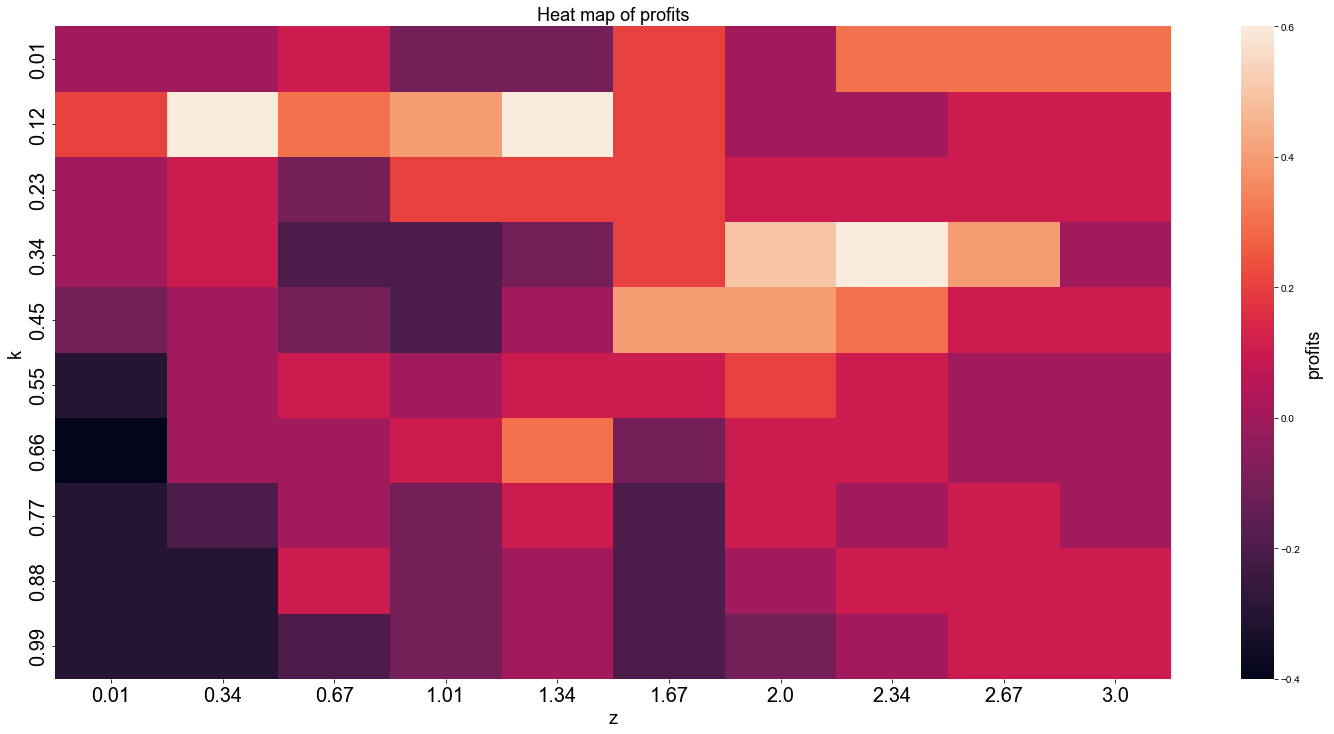

In [10]:
heatmap("k", "z","profits", storage)

According to this heatmap, the hyperparamters which are sustainably optimal are k = 0.34 and z = 2.34

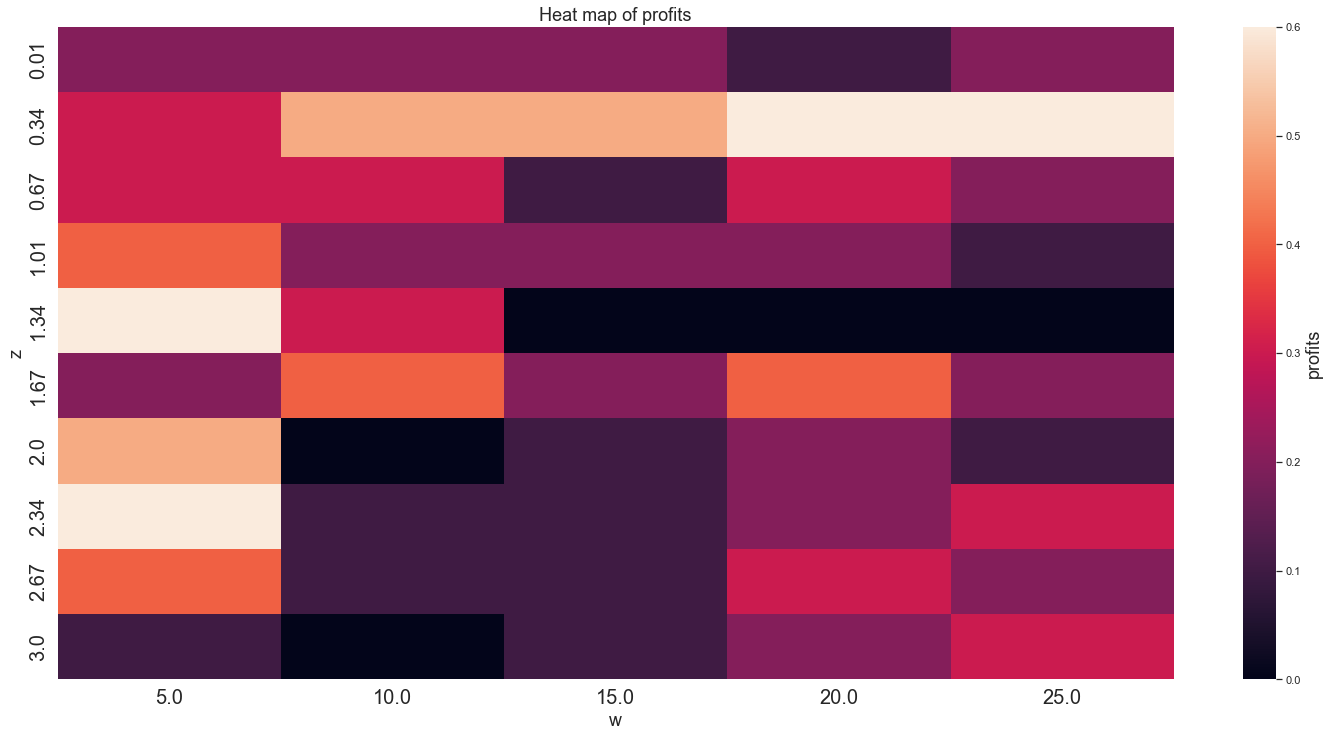

In [14]:
heatmap("z", "w","profits", storage)

According to this heatmap, the hyperparamters which are sustainably optimal are w = 5.0 and z = 2.34

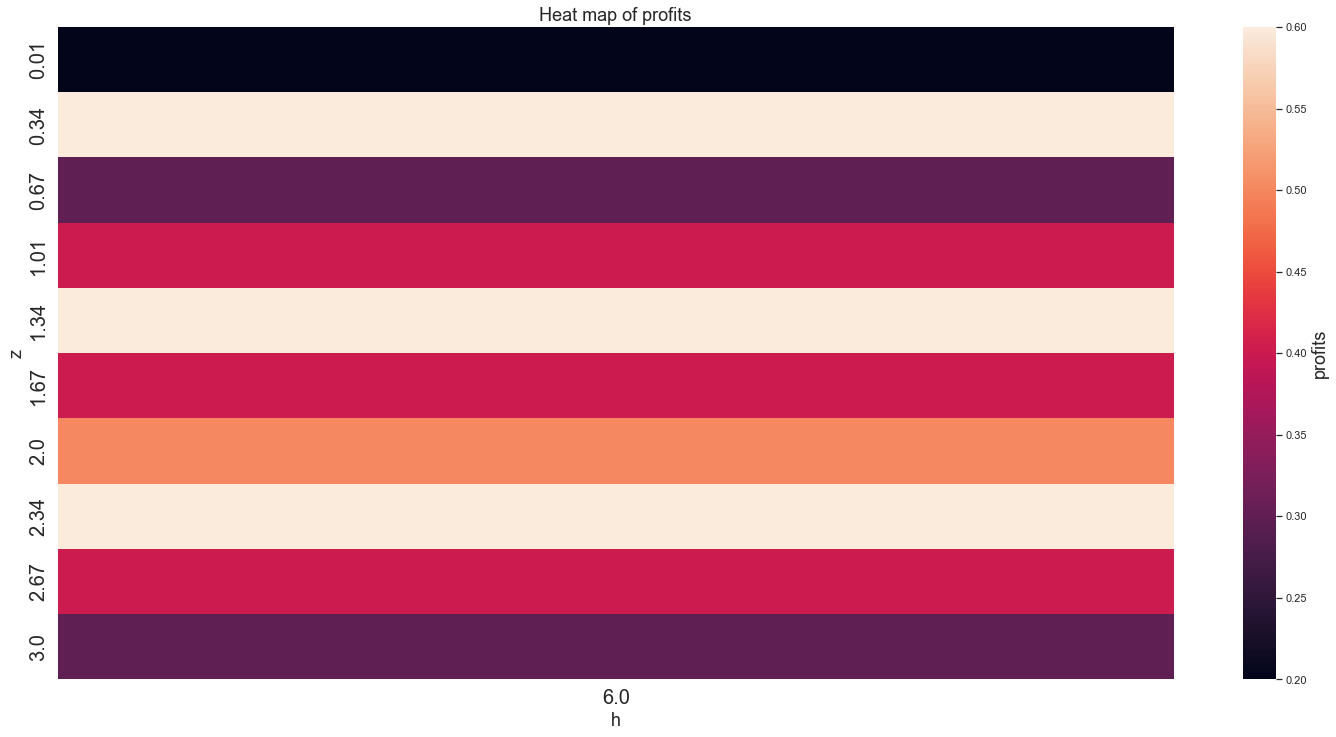

In [122]:
heatmap("z", "h","profits", storage)

According to this heatmap, the hyperparamters which are sustainably optimal are h = 6.0 and z = 2.34

Hence we can conclude that our optimal parameters are k = 0.34, z = 2.34, w = 5.0 and h = 6.0 

In [188]:
k = 0.34
z = 2.34
w = 5.0
h = 6.0 

In [189]:
df_copy = interest.copy()

In [190]:
df_copy["Filter"] = df_copy["ir_diff"].ewm(alpha = k, adjust = False).mean()
df_copy["Filter Error"] = df_copy["ir_diff"] -df_copy["Filter"]
df_copy["std"] = df_copy["Filter Error"].rolling(int(w)).std()
df_copy["Upper"] = df_copy["Filter"] + z*df_copy["std"]
df_copy["Lower"] = df_copy["Filter"] - z*df_copy["std"]
df_copy["test"] = np.where(df_copy["Filter Error"].abs()>z*df_copy["std"], 1, 0)*np.sign(df_copy["Filter Error"])

# create vectors where we can store information on signals and when the change is first signalled
df_copy["test2"] = 0
df_copy["signal"] = 0

for j in df_copy.index:
    # if there is a change in the signal, we want to take a position for teh next h periods
    if (df_copy.loc[j, "test"] == 1) &  (df_copy.shift().loc[j, "test"] != 1):
        df_copy.loc[j:j+datetime.timedelta(h), "signal"] = 1
        df_copy.loc[j, "test2"] = 1
    elif (df_copy.loc[j, "test"] == -1) &  (df_copy.shift().loc[j, "test"] != -1):
        df_copy.loc[j:j+datetime.timedelta(h), "signal"] =  -1
        df_copy.loc[j, "test2"] = -1

# calculate metric
df_copy["cumulative_returns"] = np.exp((df_copy["signal"].shift()*df_copy.Returns).cumsum())-1
df_copy["strat_returns"] = df_copy["signal"].shift()*df_copy.Returns


In [191]:
df_copy

,I_US,I_AU,AUD,ir_diff,Returns,Filter,Filter Error,std,Upper,Lower,test,test2,signal,cumulative_returns,strat_returns
Date,,,,,,,,,,,,,,,
1980-01-01,13.39,10.03,1.1067,0.247933,NaN,0.247933,0.000000,NaN,NaN,NaN,0.0,0,0,NaN,NaN
1980-02-01,14.30,10.06,1.0970,0.295560,-0.008803,0.264126,0.031434,NaN,NaN,NaN,0.0,0,0,0.000000,-0.000000
1980-03-01,17.57,11.47,1.0818,0.405795,-0.013953,0.312293,0.093502,NaN,NaN,NaN,0.0,0,0,0.000000,-0.000000
1980-04-01,16.14,13.28,1.1150,0.244089,0.030228,0.289104,-0.045015,NaN,NaN,NaN,-0.0,0,0,0.000000,0.000000
1980-05-01,9.79,13.83,1.1428,-0.123769,0.024627,0.148727,-0.272496,0.140173,0.476733,-0.179278,-0.0,0,0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-01,2.76,2.31,0.6866,0.036281,-0.017183,0.028313,0.007968,0.003519,0.036548,0.020078,0.0,0,0,0.478653,-0.000000
2022-09-01,3.21,2.76,0.6437,0.039479,-0.064519,0.032109,0.007369,0.003395,0.040053,0.024166,0.0,0,0,0.478653,-0.000000
2022-10-01,3.85,2.95,0.6394,0.065075,-0.006703,0.043317,0.021757,0.007272,0.060334,0.026301,1.0,1,1,0.478653,-0.000000


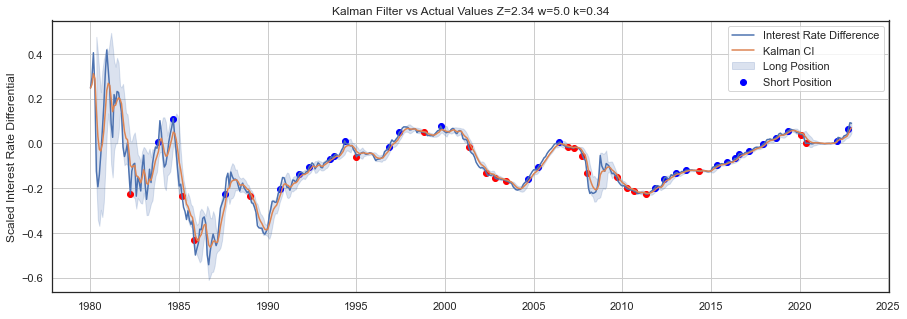

In [192]:
sns.set_style("white")
fig, ax = plt.subplots(figsize = (15, 5))
ax.set_title("Kalman Filter vs Actual Values " + "Z="+str(z) + " w=" + str(w)+ " k=" + str(k))

ax.set_ylabel("Scaled Interest Rate Differential")
ax.plot(df_copy["ir_diff"])
ax.plot(df_copy["Filter"])


ax.fill_between(df_copy.index, df_copy.Lower, df_copy.Upper, color='b', alpha=.2)
ax.scatter(df_copy[df_copy.test2 == 1].index, df_copy[df_copy.test2 == 1]["ir_diff"], color = "blue")
ax.scatter(df_copy[df_copy.test2 == -1].index, df_copy[df_copy.test2 == -1]["ir_diff"], color = "red")

#ax.axvline(df_copy.index[-5], color = "red", linestyle = '--')
ax.legend(["Interest Rate Difference", "Kalman CI", "Long Position", "Short Position"])


#plt.xlim([datetime.date(2000, 1, 1), datetime.date(2004, 1, 1)])
ax.grid()

In [193]:
df_copy["success"] = ((df_copy[df_copy.test2 != 0]["cumulative_returns"].diff()>0)*1).shift(-1)

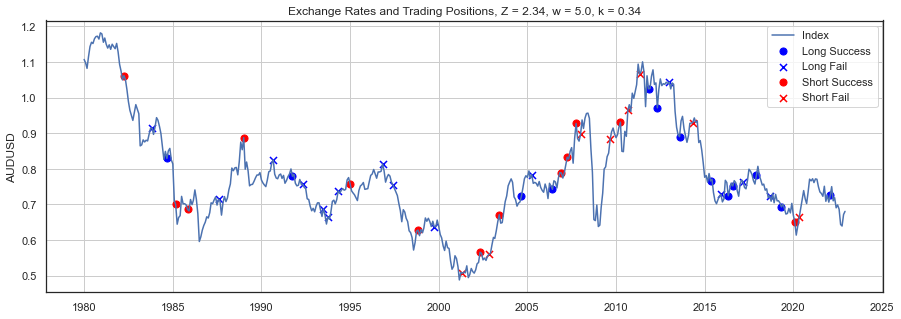

In [194]:
plt.figure(figsize = (15, 5))

plt.title("Exchange Rates and Trading Positions"+ ", Z = "+str(z) + ", w = " + str(w)+ ", k = " + str(k))
plt.ylabel("AUDUSD")
plt.plot(df_copy["AUD"])

longsuccess = df_copy[(df_copy["success"] == 1) & (df_copy["test2"] == 1)]
longfail = df_copy[(df_copy["success"] == 0) & (df_copy["test2"] == 1)] 
shortsuccess = df_copy[(df_copy["success"] == 1) & (df_copy["test2"] == -1)]
shortfail = df_copy[(df_copy["success"] == 0) & (df_copy["test2"] == -1)]

plt.scatter(longsuccess.index, longsuccess["AUD"], color = 'blue', s = 50)
plt.scatter(longfail.index, longfail["AUD"], color = 'blue', s = 50, marker = "x")

plt.scatter(shortsuccess.index, shortsuccess["AUD"], color = 'red', s = 50)
plt.scatter(shortfail.index, shortfail["AUD"], color = 'red', s = 50, marker = "x")

plt.legend(["Index", "Long Success", "Long Fail", "Short Success", "Short Fail"])
plt.grid()

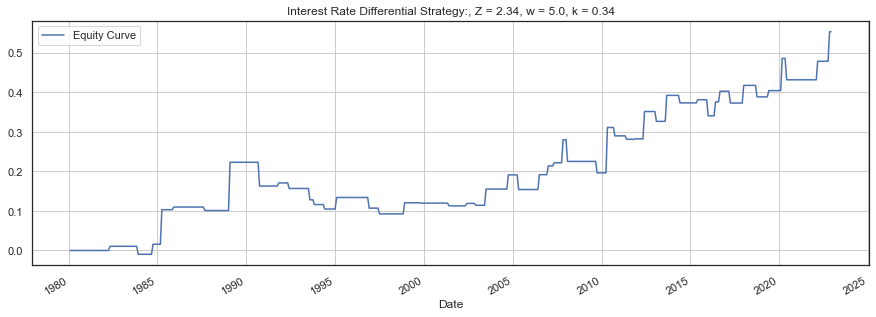

In [196]:
plt.figure(figsize = (15, 5))
(df_copy["cumulative_returns"]).plot()

plt.title("Interest Rate Differential Strategy:"+ ", Z = "+str(z) + ", w = " + str(w)+ ", k = " + str(k))

plt.legend(["Equity Curve"])

plt.grid()

### Binomial Test

In [197]:
df = df_copy[df_copy.test2 != 0][["signal", "AUD"]].copy()
df['D'] = df["signal"]

In [198]:
df2 = df[:-1].copy()

In [199]:
df2

,signal,AUD,D
Date,,,
1982-04-01,-1,1.0614,-1
1983-11-01,1,0.9147,1
1984-09-01,1,0.8290,1
1985-03-01,-1,0.7000,-1
1985-11-01,-1,0.6859,-1
1987-08-01,1,0.7145,1
1989-01-01,-1,0.8874,-1
1990-09-01,1,0.8254,1
1991-10-01,1,0.7791,1


In [200]:
df2.index = df2.index + pd.DateOffset(months=6)

In [51]:
dy = df2['W'] - np.mean(df2['W'])
gamma_0 = sum((dy)**2)/len(df2)
gamma_1 = np.mean((dy*dy.shift(-1))[:len(df2)-1])
LRV = gamma_0 + 2*(1-1/2)*gamma_1

In [52]:
from scipy.stats import norm

statistic = T_B/np.sqrt(LRV/df.shape[0])
print('Test statistic : ', statistic, ', 5 % critical value : ', round(norm.ppf(0.95),2))

Test statistic :  nan , 5 % critical value :  1.64


/var/folders/32/6tv1kbfx7jn9vst5h14cqq4r0000gn/T/ipykernel_83888/78748941.py:3: RuntimeWarning: invalid value encountered in double_scalars
  statistic = T_B/np.sqrt(LRV/df.shape[0])


In [ ]:
#since statistics is close to 0 => fail to reject H0 => forecasts couldn't really capture the actual changes

The sample covariance is pretty close to zero, so unlikely to reject.

# Metrics

## 1. Geometric Average Monthly

The geometric average return formula (also known as geometric mean return) is a way to calculate the average rate of return on an investment that is compounded over multiple periods.

\begin{equation*}
Geometric Avg. = \sqrt[m]({1+r_1} \times (1 + r_2) \times \ldots \times (1 + r_m) - 1)
\end{equation*}

In [71]:
df_copy

,I_US,I_AU,AUD,ir_diff,Returns,Filter,Filter Error,std,Upper,Lower,test,test2,signal,cumulative_returns,strat_returns,success
Date,,,,,,,,,,,,,,,,
1980-01-01,13.39,10.03,1.1067,0.247933,NaN,0.247933,0.000000,NaN,NaN,NaN,0.0,0,0,NaN,NaN,NaN
1980-02-01,14.30,10.06,1.0970,0.295560,-0.008803,0.264126,0.031434,NaN,NaN,NaN,0.0,0,0,0.000000,-0.000000,NaN
1980-03-01,17.57,11.47,1.0818,0.405795,-0.013953,0.312293,0.093502,NaN,NaN,NaN,0.0,0,0,0.000000,-0.000000,NaN
1980-04-01,16.14,13.28,1.1150,0.244089,0.030228,0.289104,-0.045015,NaN,NaN,NaN,-0.0,0,0,0.000000,0.000000,NaN
1980-05-01,9.79,13.83,1.1428,-0.123769,0.024627,0.148727,-0.272496,0.140173,0.476733,-0.179278,-0.0,0,0,0.000000,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-01,2.76,2.31,0.6866,0.036281,-0.017183,0.028313,0.007968,0.003519,0.036548,0.020078,0.0,0,0,0.478653,-0.000000,NaN
2022-09-01,3.21,2.76,0.6437,0.039479,-0.064519,0.032109,0.007369,0.003395,0.040053,0.024166,0.0,0,0,0.478653,-0.000000,NaN
2022-10-01,3.85,2.95,0.6394,0.065075,-0.006703,0.043317,0.021757,0.007272,0.060334,0.026301,1.0,1,1,0.478653,-0.000000,NaN


In [79]:
import math
multipliers = [x + 1 for x in df_copy.strat_returns[1:]]
geometric_return = (math.prod(multipliers) ** (1/len(df_copy.strat_returns[1:]))) - 1

print("Geometric average monthly return:", geometric_return)


Geometric average monthly return: 0.0008000140776092124


## 2. Standard Deviation

In [82]:
standard_dev = np.std(df_copy.strat_returns[1:])
print("Standard Deviation:", standard_dev)

Standard Deviation: 0.010824536025228695


## 3. High Month

In [92]:
high_month = df_copy.strat_returns[1:].max()
high_month_index = df_copy[df_copy['strat_returns'] == high_month].index[0]
print("High Month:", high_month)
print("Index of High Month:", high_month_index)

High Month: 0.10518523740314897
Index of High Month: 1989-02-01 00:00:00


## 4. Low Month

In [98]:
low_month = df_copy.strat_returns[1:].min()
low_month_index = df_copy[df_copy['strat_returns'] == low_month].index[0]
print("Low Month:", low_month)
print("Index of Low Month:", low_month_index)

Low Month: -0.05043920906732807
Index of Low Month: 1990-10-01 00:00:00


## 5. Annualized Return

In [99]:
P = 1000
A = (1+df_copy.cumulative_returns[-1])*P
T = len(df_copy)/12

In [101]:
arr = ((A/P)**(1/T)-1)*100
print("Annualized Return:", arr)

Annualized Return: 1.0314881182441393


## 7. Annualized Standard Deviation

In [102]:
P = 1000
A = (1+df_copy.strat_returns[-1])*P
T = len(df_copy)/12

In [104]:
astd = np.std(df_copy.strat_returns[1:])**(1/T)

print("Annualized Standard Deviation:", astd)

Annualized Standard Deviation: 0.8999115547136031


## 8. Risk Free Rate

In [202]:
risk_free = pd.read_csv('1-year-treasury-rate-yield-chart.csv', index_col=0, parse_dates = True)

In [203]:
df_copy = pd.merge_asof(df_copy, risk_free, left_index = True, right_index = True)

In [204]:
df_copy

,I_US,I_AU,AUD,ir_diff,Returns,Filter,Filter Error,std,Upper,Lower,test,test2,signal,cumulative_returns,strat_returns,success,value
Date,,,,,,,,,,,,,,,,,
1980-01-01,13.39,10.03,1.1067,0.247933,NaN,0.247933,0.000000,NaN,NaN,NaN,0.0,0,0,NaN,NaN,NaN,11.70
1980-02-01,14.30,10.06,1.0970,0.295560,-0.008803,0.264126,0.031434,NaN,NaN,NaN,0.0,0,0,0.000000,-0.000000,NaN,12.62
1980-03-01,17.57,11.47,1.0818,0.405795,-0.013953,0.312293,0.093502,NaN,NaN,NaN,0.0,0,0,0.000000,-0.000000,NaN,15.45
1980-04-01,16.14,13.28,1.1150,0.244089,0.030228,0.289104,-0.045015,NaN,NaN,NaN,-0.0,0,0,0.000000,0.000000,NaN,15.85
1980-05-01,9.79,13.83,1.1428,-0.123769,0.024627,0.148727,-0.272496,0.140173,0.476733,-0.179278,-0.0,0,0,0.000000,0.000000,NaN,11.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-01,2.76,2.31,0.6866,0.036281,-0.017183,0.028313,0.007968,0.003519,0.036548,0.020078,0.0,0,0,0.478653,-0.000000,NaN,2.98
2022-09-01,3.21,2.76,0.6437,0.039479,-0.064519,0.032109,0.007369,0.003395,0.040053,0.024166,0.0,0,0,0.478653,-0.000000,NaN,3.51
2022-10-01,3.85,2.95,0.6394,0.065075,-0.006703,0.043317,0.021757,0.007272,0.060334,0.026301,1.0,1,1,0.478653,-0.000000,NaN,4.05


## 9. Sharpe Ratio

In [124]:
sharpe = df_copy.copy()

In [126]:
sharpe.columns

Index(['I_US', 'I_AU', 'AUD', 'ir_diff', 'Returns', 'Filter', 'Filter Error',
       'std', 'Upper', 'Lower', 'test', 'test2', 'signal',
       'cumulative_returns', 'strat_returns', 'success', ' value'],
      dtype='object')

In [115]:
return_df = sharpe[["strat_returns"]].dropna().copy()

In [127]:
return_df["rfr"] = (sharpe[[' value']].dropna()/100+1)**(1/12)-1

In [129]:
return_df["excess_return"] = return_df["strat_returns"] - return_df["rfr"]

In [130]:
sharpe_ratio = (return_df['excess_return'].mean())/(return_df['excess_return'].std())

In [131]:
sharpe_ratio

-0.24420226494556938

## 10. Number of Winning Months

In [147]:
wins = len(df_copy[df_copy['strat_returns'] > 0])
(wins/515)*100

5.242718446601942

## 11. Max. Drawdown

In [228]:
(((df_copy.cumulative_returns) - (df_copy.cumulative_returns).cummax())/(df_copy.cumulative_returns).cummax()).min()

-1.9026057871581066

## 12. Alpha and Beta

In [205]:
risk_free = risk_free.resample('M').first()
risk_free

,value
date,
1962-01-31,3.22
1962-02-28,3.30
1962-03-31,3.15
1962-04-30,2.95
1962-05-31,3.06
...,...
2022-09-30,3.51
2022-10-31,4.01
2022-11-30,4.75


In [206]:
sp500 = yf.download("^GSPC")

[*********************100%***********************]  1 of 1 completed


In [207]:
sp500['pct_change'] = sp500['Adj Close'].diff()/sp500['Adj Close']+1

In [208]:
sp500['difference'] = sp500['Adj Close'].diff()

In [209]:
sp500 = pd.DataFrame(sp500['pct_change'])

In [210]:
sp500 = sp500.resample('M').prod()-1

In [211]:
df_copy['risk_monthly'] = (df_copy[' value']*0.01+1)**(1/12)-1
df_copy

,I_US,I_AU,AUD,ir_diff,Returns,Filter,Filter Error,std,Upper,Lower,test,test2,signal,cumulative_returns,strat_returns,success,value,risk_monthly
Date,,,,,,,,,,,,,,,,,,
1980-01-01,13.39,10.03,1.1067,0.247933,NaN,0.247933,0.000000,NaN,NaN,NaN,0.0,0,0,NaN,NaN,NaN,11.70,0.009263
1980-02-01,14.30,10.06,1.0970,0.295560,-0.008803,0.264126,0.031434,NaN,NaN,NaN,0.0,0,0,0.000000,-0.000000,NaN,12.62,0.009953
1980-03-01,17.57,11.47,1.0818,0.405795,-0.013953,0.312293,0.093502,NaN,NaN,NaN,0.0,0,0,0.000000,-0.000000,NaN,15.45,0.012044
1980-04-01,16.14,13.28,1.1150,0.244089,0.030228,0.289104,-0.045015,NaN,NaN,NaN,-0.0,0,0,0.000000,0.000000,NaN,15.85,0.012336
1980-05-01,9.79,13.83,1.1428,-0.123769,0.024627,0.148727,-0.272496,0.140173,0.476733,-0.179278,-0.0,0,0,0.000000,0.000000,NaN,11.11,0.008818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-01,2.76,2.31,0.6866,0.036281,-0.017183,0.028313,0.007968,0.003519,0.036548,0.020078,0.0,0,0,0.478653,-0.000000,NaN,2.98,0.002450
2022-09-01,3.21,2.76,0.6437,0.039479,-0.064519,0.032109,0.007369,0.003395,0.040053,0.024166,0.0,0,0,0.478653,-0.000000,NaN,3.51,0.002879
2022-10-01,3.85,2.95,0.6394,0.065075,-0.006703,0.043317,0.021757,0.007272,0.060334,0.026301,1.0,1,1,0.478653,-0.000000,NaN,4.05,0.003314


In [212]:
df_copy = pd.merge_asof(df_copy, sp500, left_index = True, right_index = True, direction = "backward")

In [213]:
df_copy['Profits_pct_change'] = df_copy["strat_returns"].pct_change()

In [236]:
df_copy['profit_excess'] = df_copy['strat_returns'] - df_copy['risk_monthly']
df_copy['market_excess'] = df_copy['pct_change']- df_copy['risk_monthly']

In [237]:
df3 = df_copy.copy()

In [238]:
df3

,I_US,I_AU,AUD,ir_diff,Returns,Filter,Filter Error,std,Upper,Lower,...,signal,cumulative_returns,strat_returns,success,value,risk_monthly,pct_change,Profits_pct_change,profit_excess,market_excess
Date,,,,,,,,,,,,,,,,,,,,,
1980-01-01,13.39,10.03,1.1067,0.247933,NaN,0.247933,0.000000,NaN,NaN,NaN,...,0,NaN,NaN,NaN,11.70,0.009263,0.016293,NaN,NaN,0.007030
1980-02-01,14.30,10.06,1.0970,0.295560,-0.008803,0.264126,0.031434,NaN,NaN,NaN,...,0,0.000000,-0.000000,NaN,12.62,0.009953,0.055629,NaN,-0.009953,0.045675
1980-03-01,17.57,11.47,1.0818,0.405795,-0.013953,0.312293,0.093502,NaN,NaN,NaN,...,0,0.000000,-0.000000,NaN,15.45,0.012044,-0.006272,NaN,-0.012044,-0.018316
1980-04-01,16.14,13.28,1.1150,0.244089,0.030228,0.289104,-0.045015,NaN,NaN,NaN,...,0,0.000000,0.000000,NaN,15.85,0.012336,-0.106036,NaN,-0.012336,-0.118372
1980-05-01,9.79,13.83,1.1428,-0.123769,0.024627,0.148727,-0.272496,0.140173,0.476733,-0.179278,...,0,0.000000,0.000000,NaN,11.11,0.008818,0.038378,NaN,-0.008818,0.029560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-01,2.76,2.31,0.6866,0.036281,-0.017183,0.028313,0.007968,0.003519,0.036548,0.020078,...,0,0.478653,-0.000000,NaN,2.98,0.002450,0.087750,NaN,-0.002450,0.085300
2022-09-01,3.21,2.76,0.6437,0.039479,-0.064519,0.032109,0.007369,0.003395,0.040053,0.024166,...,0,0.478653,-0.000000,NaN,3.51,0.002879,-0.045708,NaN,-0.002879,-0.048587
2022-10-01,3.85,2.95,0.6394,0.065075,-0.006703,0.043317,0.021757,0.007272,0.060334,0.026301,...,1,0.478653,-0.000000,NaN,4.05,0.003314,-0.098036,NaN,-0.003314,-0.101350


In [239]:
df3 = df3[["profit_excess", "market_excess"]].dropna()

In [240]:
df3 = df3.replace([np.inf, -np.inf], np.nan).dropna() 

In [241]:
ols = smf.ols(formula = 'profit_excess ~ market_excess', data = df3).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          profit_excess   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.2758
Date:                Thu, 23 Mar 2023   Prob (F-statistic):              0.600
Time:                        19:29:07   Log-Likelihood:                 1579.3
No. Observations:                 514   AIC:                            -3155.
Df Residuals:                     512   BIC:                            -3146.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.0028      0.000     -5.551      0.000      -0.004      -0.002
market_excess     0.0057      0.011      0.525      0.600      -0.016       0.027
==============================================================================
Omnibus:                      482.409   Durbin-Watson:                   1.880
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            22579.362
Skew:                           3.951   Prob(JB):                         0.00
Kurtosis:                      34.494   Cond. No.                         22.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

So alpha is -0.0028 and beta is 0.0057

## 13. Monthly R-Sqaured

= 0.001

## 14. Correlation

In [243]:
df3.corr()

,profit_excess,market_excess
profit_excess,1.000000,0.023205
market_excess,0.023205,1.000000


## 15. Up Alpha and Up Beta

### for Snehil: 
In the context of the HFRI index, "up alpha" generally refers to a hedge fund's ability to generate positive returns above and beyond the market return or benchmark index. It indicates that the hedge fund has outperformed its expected returns, based on its level of risk, and has added value to its investors' portfolios.

Alpha is a measure of a hedge fund's risk-adjusted performance, and it is calculated by subtracting the fund's expected return based on its level of risk (as measured by beta) from its actual return. A positive alpha indicates that the hedge fund has outperformed its expected return, while a negative alpha indicates that it has underperformed.

So when the HFRI index reports "up alpha," it means that the hedge funds in the index have, on average, generated positive returns that exceed their expected returns based on their level of risk, and have therefore added value to their investors' portfolios.

In [244]:
up = df3[df3["profit_excess"] > 0]

In [246]:
ols = smf.ols(formula = 'profit_excess ~ market_excess', data = up).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          profit_excess   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.039
Method:                 Least Squares   F-statistic:                   0.09879
Date:                Thu, 23 Mar 2023   Prob (F-statistic):              0.756
Time:                        19:30:13   Log-Likelihood:                 55.716
No. Observations:                  25   AIC:                            -107.4
Df Residuals:                      23   BIC:                            -105.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0322      0.005      5.933      0.000       0.021       0.043
market_excess     0.0461      0.147      0.314      0.756      -0.258       0.350
==============================================================================
Omnibus:                        4.942   Durbin-Watson:                   2.072
Prob(Omnibus):                  0.085   Jarque-Bera (JB):                3.711
Skew:                           0.942   Prob(JB):                        0.156
Kurtosis:                       3.126   Cond. No.                         27.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

--interprettttt

## 16. Up R Squared

0.004

## 17. Down Alpha and Down Beta

In [247]:
down = df3[df3["profit_excess"] < 0]

In [248]:
ols = smf.ols(formula = 'profit_excess ~ market_excess', data = down).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          profit_excess   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.698
Date:                Thu, 23 Mar 2023   Prob (F-statistic):              0.193
Time:                        19:32:03   Log-Likelihood:                 1841.0
No. Observations:                 489   AIC:                            -3678.
Df Residuals:                     487   BIC:                            -3670.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.0045      0.000    -17.853      0.000      -0.005      -0.004
market_excess     0.0072      0.006      1.303      0.193      -0.004       0.018
==============================================================================
Omnibus:                      459.122   Durbin-Watson:                   1.632
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14627.325
Skew:                          -4.105   Prob(JB):                         0.00
Kurtosis:                      28.505   Cond. No.                         21.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 18. Down R Squared

= 0.003